In [2]:
import os
import glob
import sys
import argparse
import numpy as np
import torch
from torch.autograd import grad
import torch.nn.functional as F
from utils import display_progress

from torch.nn.utils import clip_grad_norm_
from torchvision.utils import save_image, make_grid

from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from datasets import load_dataset
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from torchinfo import summary

from scheduler import DDIMScheduler
from model import UNet
from utils import save_images, normalize_to_neg_one_to_one, plot_losses, set_seed
import pandas as pd
from torch.utils.data import DataLoader, Dataset, Subset

import torch.distributed as dist
import torch.multiprocessing as mp

import pickle
from datetime import datetime
import pytz

from matplotlib import pyplot as plt
import random

In [3]:
resolution = 64

augmentations = Compose([
    Resize(resolution, interpolation=InterpolationMode.BILINEAR),
    CenterCrop(resolution),
    # RandomHorizontalFlip(),
    ToTensor(),
])
def transform(examples):
    images = [
        augmentations(image.convert("RGB"))
        for image in examples["image"]
        # for image in examples["img"]
    ]
    return {"input": images}

dataset = load_dataset(
    'zh-plus/tiny-imagenet',
    cache_dir='dataset/tinyimagenet',
    split="train",
)
dataset.set_transform(transform)

In [4]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
set_seed(16)
random_samples = random.sample(range(0, len(data_loader.dataset)), 16)
np.array(random_samples)

array([47385, 61501, 62977, 37346, 54650, 29706, 58557,   767, 53676,
       86206, 93192, 33928, 31176, 83230, 29154,  1327])

In [57]:
influence_result = torch.load('influence/tiny_imagenet/tracin/random/30/30_results')
influence_result['helpful'].shape

(16, 100000)

In [58]:
n = 50
unique = []
for influence in influence_result['helpful']:
    unique += list(influence[:n])

unique = np.unique(unique)
print(len(unique) / (16 * n))

0.4675


In [59]:
influence_result['helpful'][0][:6]

array([59266, 93414, 98156,  6299, 66574,  6033])

In [60]:
influence_result['helpful'][4][:6]

array([76350,  4533, 66574, 70570, 32788, 70746])

In [61]:
influence_result['helpful'][11][:6]

array([32695, 75186, 33912, 33696, 40529, 98051])

In [51]:
fish_influence_result = torch.load('influence/tiny_imagenet/tracin/20/20_results')

In [55]:
planes_to_plot = []

def extract(influence_result, idx):
    res = []
    for i in range(6):
        res.append(np.array(data_loader.dataset[int(influence_result['helpful'][idx][i])]['input']).transpose(1, 2, 0))
        
    return res

planes_to_plot += extract(influence_result, 0)
planes_to_plot += extract(influence_result, 4)
planes_to_plot += extract(influence_result, 11)
planes_to_plot += extract(fish_influence_result, 11)
# planes_to_plot += extract(influence_result, 11)

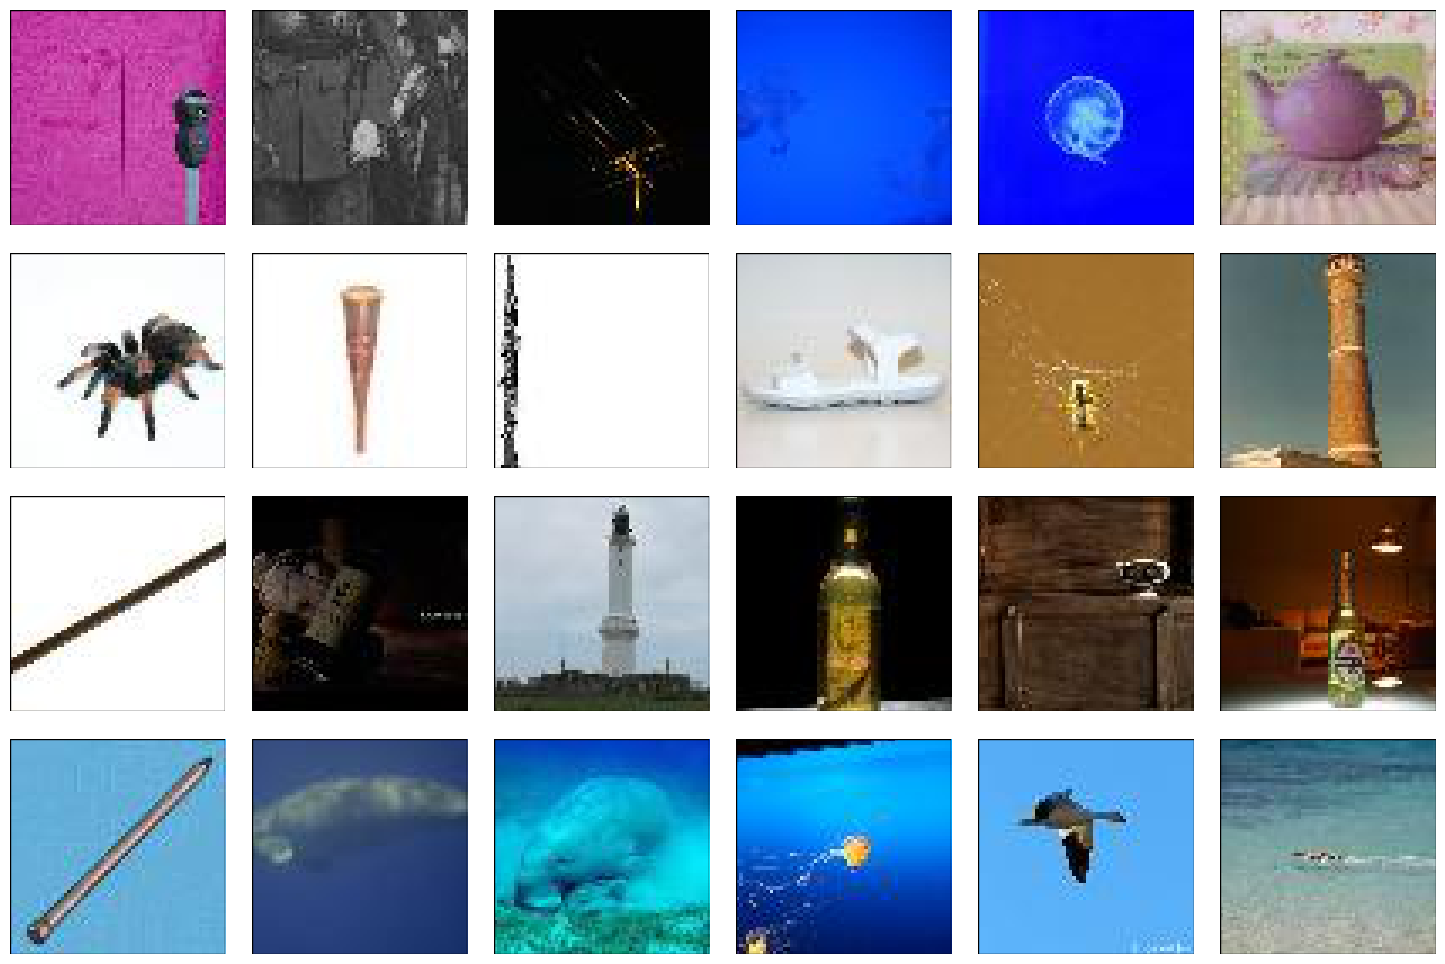

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming planes_to_plot contains your 24 images
# Replace this list with your actual image data
# planes_to_plot = [np.random.rand(100, 100, 3) for _ in range(24)]
# planes_to_plot = [np.array(data_loader.dataset[int(influence_result['helpful'][0][i])]['input']).transpose(1, 2, 0) for i in range(24)]
captions = [f'Image {i+1}' for i in range(24)]

# fig, ax = plt.subplots(figsize=(15, 10))

fig, axs = plt.subplots(4, 6, figsize=(15, 10))  # Use axs to handle multiple axes

# Adjust subplot parameters to accommodate captions below images
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.4, wspace=0.2)

for i, ax in enumerate(axs.flat):  # Flatten axs for easy iteration
    if i < len(planes_to_plot):
        img = ax.imshow(planes_to_plot[i], extent=[0, 1, 0, 1])
        ax.axis('off')  # Hide axes for each subplot individually
        # ax.set_title(captions[i], fontsize=8, pad=4)  # Set image caption

        extent = img.get_extent()
        
        # Create a rectangle around the image, using image extents
        rect = patches.Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                                 linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    else:
        ax.axis('off')  # Ensure no axis for empty subplots

plt.tight_layout(pad=2.0)  # Adjust the layout
plt.savefig('TracIn_new.png', dpi=300)


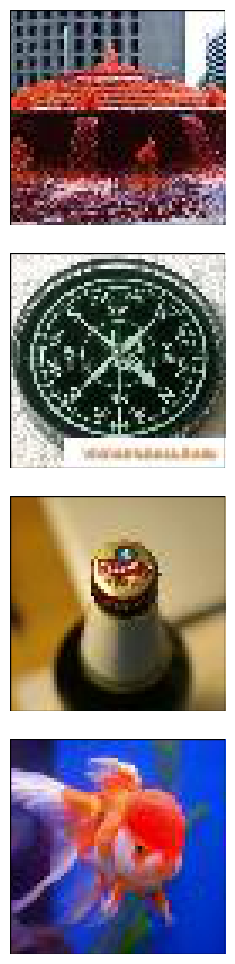

In [17]:
# Assuming planes_to_plot contains your 24 images
# Replace this list with your actual image data
# planes_to_plot = [np.random.rand(100, 100, 3) for _ in range(24)]
# planes_to_plot = [np.array(data_loader.dataset[int(influence_result['helpful'][0][i])]['input']).transpose(1, 2, 0) for i in range(24)]
images_to_draw = []

def extract_data_fromdataset(i):
    return np.array(data_loader.dataset[i]['input']).transpose(1, 2, 0)

images_to_draw.append(extract_data_fromdataset(random_samples[0]))
images_to_draw.append(extract_data_fromdataset(random_samples[4]))
images_to_draw.append(extract_data_fromdataset(random_samples[11]))
images_to_draw.append(extract_data_fromdataset(11))
captions = [f'Image {i+1}' for i in range(24)]

# fig, ax = plt.subplots(figsize=(15, 10))

fig, axs = plt.subplots(4, 1, figsize=(15, 10))  # Use axs to handle multiple axes

# Adjust subplot parameters to accommodate captions below images
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.4, wspace=0.2)

for i, ax in enumerate(axs.flat):  # Flatten axs for easy iteration
    if i < len(images_to_draw):
        img = ax.imshow(images_to_draw[i], extent=[0, 1, 0, 1])
        ax.axis('off')  # Hide axes for each subplot individually
        # ax.set_title(captions[i], fontsize=8, pad=4)  # Set image caption

        extent = img.get_extent()
        
        # Create a rectangle around the image, using image extents
        rect = patches.Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                                 linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    else:
        ax.axis('off')  # Ensure no axis for empty subplots
plt.tight_layout(pad=2.0)  # Adjust the layout
plt.savefig('sample.png', dpi=300)

In [75]:
influence_function_result = torch.load('planes.pkl')

In [77]:
result_1 = influence_function_result[1]
result_3 = influence_function_result[3]

In [79]:
zero_influence_function_result = torch.load('zeros.pkl')

In [81]:
zero_result_1 = zero_influence_function_result[5001]
zero_result_2 = zero_influence_function_result[5004]

In [93]:
from datasets import concatenate_datasets

resolution = 32

augmentations = Compose([
    Resize(resolution, interpolation=InterpolationMode.BILINEAR),
    CenterCrop(resolution),
    # RandomHorizontalFlip(),
    ToTensor(),
])
def transform(examples):
    images = [
        augmentations(image.convert("RGB"))
        # for image in examples["image"]
        for image in examples["img"]
    ]
    return {"input": images}

dataset = load_dataset('cifar10',cache_dir='./dataset/cifar10', split='train')
dataset = dataset.filter(lambda data: data['label'] == 0)
mnist = load_dataset("mnist", split="train")
mnist_0 = mnist.filter(lambda data: data['label'] == 0).rename_column("image", "img")
mnist_0_200 = mnist_0.select(range(200))
mnist_0_200 = mnist_0_200.remove_columns("label")
dataset = concatenate_datasets([dataset, mnist_0_200])
dataset.set_transform(transform)

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [98]:
to_plot = []

def extract(influence_result):
    helpful = np.flip(torch.argsort(influence_result).numpy())
    res = []
    for i in range(6):
        res.append(np.array(data_loader.dataset[int(helpful[i])]['input']).transpose(1, 2, 0))
        
    return res

to_plot += extract(result_1)
to_plot += extract(result_3)
to_plot += extract(zero_result_1)
to_plot += extract(zero_result_2)

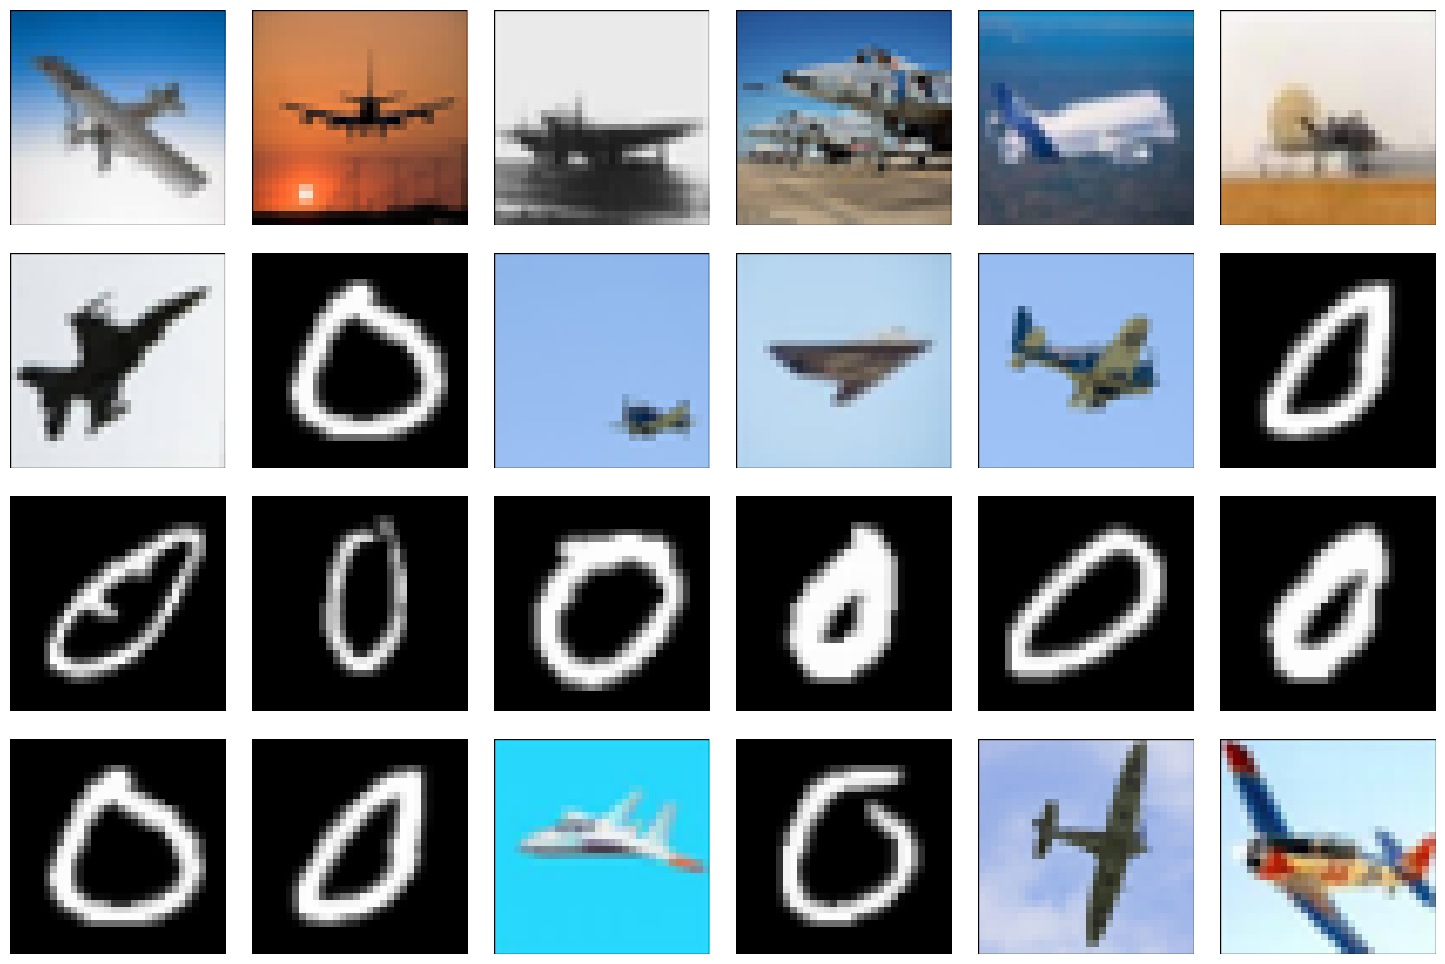

In [99]:
captions = [f'Image {i+1}' for i in range(24)]

# fig, ax = plt.subplots(figsize=(15, 10))

fig, axs = plt.subplots(4, 6, figsize=(15, 10))  # Use axs to handle multiple axes

# Adjust subplot parameters to accommodate captions below images
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.4, wspace=0.2)

for i, ax in enumerate(axs.flat):  # Flatten axs for easy iteration
    if i < len(to_plot):
        img = ax.imshow(to_plot[i], extent=[0, 1, 0, 1])
        ax.axis('off')  # Hide axes for each subplot individually
        # ax.set_title(captions[i], fontsize=8, pad=4)  # Set image caption

        extent = img.get_extent()
        
        # Create a rectangle around the image, using image extents
        rect = patches.Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                                 linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    else:
        ax.axis('off')  # Ensure no axis for empty subplots

plt.tight_layout(pad=2.0)  # Adjust the layout
plt.savefig('IF.png', dpi=300)

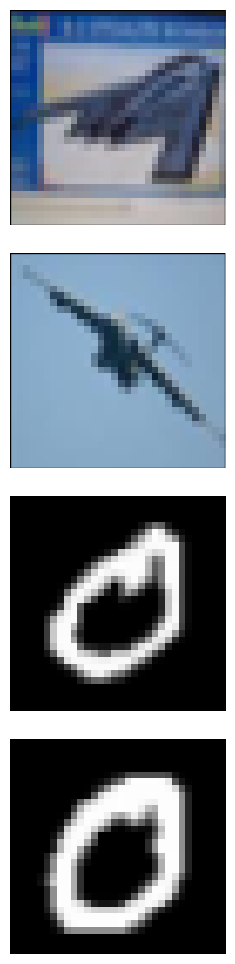

In [100]:
to_plot = []

def extract_image(idx):
    img = np.array(data_loader.dataset[idx]['input']).transpose(1, 2, 0)
    return img

to_plot.append(extract_image(1))
to_plot.append(extract_image(3))
to_plot.append(extract_image(5001))
to_plot.append(extract_image(5004))

captions = [f'Image {i+1}' for i in range(24)]

# fig, ax = plt.subplots(figsize=(15, 10))

fig, axs = plt.subplots(4, 1, figsize=(15, 10))  # Use axs to handle multiple axes

# Adjust subplot parameters to accommodate captions below images
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.4, wspace=0.2)

for i, ax in enumerate(axs.flat):  # Flatten axs for easy iteration
    if i < len(to_plot):
        img = ax.imshow(to_plot[i], extent=[0, 1, 0, 1])
        ax.axis('off')  # Hide axes for each subplot individually
        # ax.set_title(captions[i], fontsize=8, pad=4)  # Set image caption

        extent = img.get_extent()
        
        # Create a rectangle around the image, using image extents
        rect = patches.Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                                 linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    else:
        ax.axis('off')  # Ensure no axis for empty subplots

plt.tight_layout(pad=2.0)  # Adjust the layout
plt.savefig('IF_source.png', dpi=300)